# <font color = "red"> Heart Disease <font color = "sky blue"> Prediction

### Background: 
Heart disease, a widespread and serious health issue impacting the circulatory system, has emerged as a critical public health concern. According to data collected by the Canadian Chronic Disease Surveillance System (CCDSS) from 2017 to 2018, an alarming statistic has come to light: roughly 1 in 12 Canadian adults aged 20 and above, amounting to 2.6 million individuals, have received a diagnosis of heart disease. Regrettably, the gravity of the situation is underscored by the fact that, on an hourly basis, approximately 14 Canadian adults aged 20 and over, already diagnosed with heart disease, succumb to its consequences.

Given the alarming prevalence of heart disease and its associated mortality rates, it is important to establish a model capable of predicting an individual's susceptibility to heart disease.Because aging can induce changes in the heart and blood vessels, individuals aged 65 and older are significantly more likely than younger people to experience a heart attack, suffer from a stroke, or develop coronary heart disease and heart failure, according to the National Institutes of Health (NIH). Additionally, Centers for Disease Control and Prevention (CDC) state that high blood pressure and high blood cholesterol are notable contributors to heart disease risks; meanwhile, Harvard Health Publishing argues that a low maximum heart rate may signify an elevated likelihood of experiencing heart disease. In this project, the selection of key factors for assessing the risk of heart disease is informed by the aforementioned considerations, focusing on age, resting blood pressure, heart rate, and cholesterol levels.

### Question: 
- **Original question:**
    Can we use the available data for age, resting blood pressure (resting BP), cholesterol, and max heart rate (MaxHR) to predict an individual's susceptibility to heart disease?

   (However, our research has changed and the reason will be mentioned later)
- **New question:**
    Can we use the available data for <font color="red"> age, cholesterol, and max heart rate (MaxHR) <font color="black"> to predict an individual's susceptibility to heart disease?

### Dataset:
The dataset used in this project is called the Heart Failure Prediction Dataset. To meet our goal, we have selected 5 columns, which we refer to as "heart." In the "heart" dataset, there are 214 recorded observations, each with 5 different properties:
- **1. Age:** age of the patient (years)
- **2. RestingBP:** resting blood pressure (mm Hg)
- **3. Cholesterol:** serum cholesterol (mm/dl)
- **4. MaxHR:** maximum heart rate achieved (Numeric value between 60 and 202)
- **5. HeartDisease:** output class (heart disease, Normal)

In [1]:
install.packages("cowplot")
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(crayon)
library(ggplot2)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

## Load, Wrangle and Clean the Data

<font color= "grey"> Our initial step involves loading,wrangling, and cleanining the dataset through visualizations. To begin, we utilize the read_csv function to import data from "https://www.kaggle.com/datasets/fedesoriano/heart-failure-predictio", specifically selecting variables such as Age, RestingBP, Cholesterol, MaxHR, and HeartDisease. As we will be treating HeartDisease as a categorical variable, we convert it into a factor type using the as_factor function. Additionally, to enhance the clarity of our analysis, we enhance the interpretability by renaming "1" to "Disease" and "0" to "Normal" through the use of the mutate method. Also, we dropped NA data to clean up the data.

In [21]:
heart<-read_csv("https://raw.githubusercontent.com/Miranayy/DSCI100_009_019/main/heart.csv")|> 
    select(Age,RestingBP,Cholesterol,MaxHR,HeartDisease)|>
    mutate(HeartDisease=as_factor(HeartDisease))|>
    mutate(HeartDisease=fct_recode(HeartDisease,"Disease"= "1","Normal"= "0"))|>
    drop_na()

cat(bold("Table 1   "))
cat("heart data")
head(heart)

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Table 1   heart data

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,Normal
49,160,180,156,Disease
37,130,283,98,Normal
48,138,214,108,Disease
54,150,195,122,Normal
39,120,339,170,Normal


## Predictor Variable Selection

<font color= "grey"> Box plots serve as an important tool for this study to compare distributions when a categorical variable is paired with a continuous variable. To examine the association between the categorical factor “HeartDisease” and four potential predictors, we employ four box plots.

Plot 1  Predictors selection

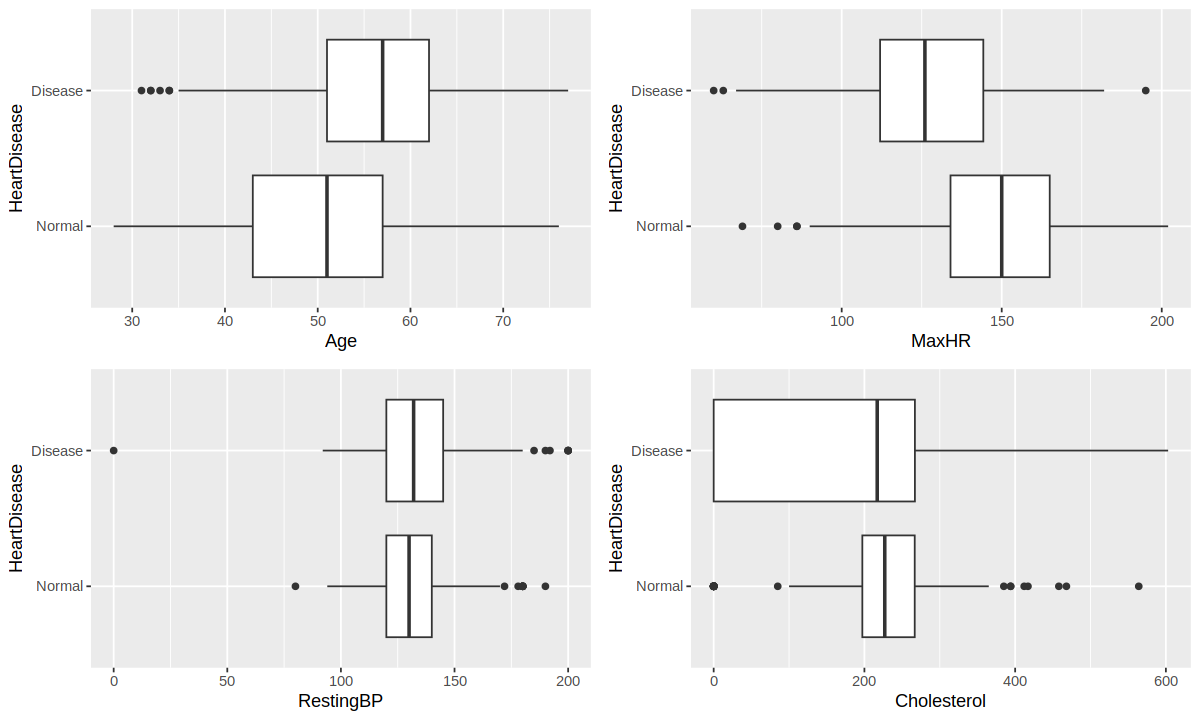

In [22]:
options(repr.plot.height = 6, repr.plot.width = 10)
## Age VS HeartDisease
age_heart<-ggplot(heart, aes(x=Age, y=HeartDisease)) + 
  geom_boxplot()

## MaxHR VS HeartDisease
MaxHR_heart<-ggplot(heart, aes(x=MaxHR, y=HeartDisease)) + 
  geom_boxplot()

## RestingBP VS HeartDisease
RestingBP_heart<-ggplot(heart, aes(x=RestingBP, y=HeartDisease)) + 
  geom_boxplot()

## Cholesterol VS HeartDisease
Cholesterol_heart<-ggplot(heart, aes(x=Cholesterol, y=HeartDisease)) + 
  geom_boxplot()

## Predictors grid
predictors_grid<-plot_grid(age_heart,MaxHR_heart,RestingBP_heart,Cholesterol_heart,ncol = 2)


cat(bold("Plot 1  "))
cat("Predictors selection")
predictors_grid

### Analysis:

- **Age VS HeartDisease:**
The medians of the two boxes are not very close to each other, so it is reasonable to use age as one of the predictors.

- **MaxHR VS HeartDisease:** 
The medians of the two boxes are not very close to each other, so it is reasonable to use MaxHR as one of the predictors.

- **RestingBP VS HeartDisease:**
The medians of the two boxes are very close to each other, which implies that the relationship between age and RestingBP is quite weak. Therefore, we choose not to include RestingBP as one of the predictors.

- **Cholesterol VS HeartDisease:**
Although the medians of the two boxes are very close to each other, the upper box for having heart disease has a larger range than the lower box. Therefore, we include Cholesterol as one of the predictors.

- **Summary:**
We select Age, MaxHR, and Cholesterol as predictors.

- **Update our question:


## Create the Train / Test Split

<font color= "grey"> The next step involves dividing the dataset into a training set and a testing set using the initial_split function. We designate prop = 0.75 to allocate 75% of the original dataset to the training set, with the remaining 25% forming the testing set. Additionally, we set the strata argument to the categorical label variable (in this case, HeartDisease) to ensure that the training and testing subsets maintain the correct proportions of each category of observation.
To ascertain the distribution within the training data, we utilize group_by and summarize to calculate the percentage of "Normal" and "Disease." Our analysis reveals that approximately 44.6% of the training data corresponds to "Normal," while 55.4% is classified as "Disease."

In [23]:
heart_new<-heart|>select(Age,Cholesterol,MaxHR,HeartDisease)

cat(bold("Table 2   "))
cat("New heart data")
head(heart_new)

Table 2   New heart data

Age,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<fct>
40,289,172,Normal
49,180,156,Disease
37,283,98,Normal
48,214,108,Disease
54,195,122,Normal
39,339,170,Normal


In [6]:
set.seed(19)
heart_new_split<-initial_split(heart_new,prop=0.75,strata=HeartDisease)
heart_new_training<-training(heart_new_split)
heart_new_testing<-testing(heart_new_split)

In [24]:
stat_age<-heart_new_training|>
    group_by(HeartDisease)|>
    summarize(mean_age=mean(Age))

stat_cholesterol<-heart_new_training|>
    group_by(HeartDisease)|>
    summarize(mean_cholesterol=mean(Cholesterol))

stat_MaxHR<-heart_new_training|>
    group_by(HeartDisease)|>
    summarize(mean_MaxHR=mean(MaxHR))

stat_training<-heart_new_training|>
    group_by(HeartDisease)|>
    summarize(count=n())|>
    inner_join(stat_age)|>
    inner_join(stat_cholesterol)|>inner_join(stat_MaxHR)

cat(bold("Table 3   "))
cat("Stat of training set")
stat_training

Joining with `by = join_by(HeartDisease)`
Joining with `by = join_by(HeartDisease)`
Joining with `by = join_by(HeartDisease)`


Table 3   Stat of training set

HeartDisease,count,mean_age,mean_cholesterol,mean_MaxHR
<fct>,<int>,<dbl>,<dbl>,<dbl>
Normal,307,50.57329,228.0912,147.9414
Disease,381,56.09186,174.0630,128.7034


In [25]:
heart_proportions <- heart_new_training |>
                      group_by(HeartDisease) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_new_training))
cat(bold("Table 4   "))
cat("Proportion of training set")
heart_proportions

Table 4   Proportion of training set

HeartDisease,n,percent
<fct>,<int>,<dbl>
Normal,307,44.62209
Disease,381,55.37791


## Tuning the Classifier

<font color="grey"> We implement cross-validation to partition our overall training data into 5 equally sized chunks. Subsequently, we iteratively designate one chunk as the validation set while combining the remaining four chunks to form the training set. In this scenario, 5 chunks of the dataset are utilized, resulting in 5 different choices for the validation set. To execute 5-fold cross-validation, the vfold_cv function is employed, automatically splitting the training data into v folds (in this case, v=5). Additionally, the strata argument is set to the categorical label variable (in this case, Heartdisease) to ensure that the training and validation subsets maintain the correct proportions for each category of observation.

<font color="grey"> In the construction of our data analysis workflow, the tune_grid function is employed, fitting the model for each value in a range of parameter values.

<font color="grey"> Then, the collect_metrics function is utilized to aggregate the mean and standard error of the classifier's validation accuracy across the folds. The results pertaining to accuracy are displayed in the row where accuracy is listed under the .metric column. The mean (mean) is considered the estimated accuracy.

In [26]:
heart_vfold<-vfold_cv(heart_new_training,v=5,strata=HeartDisease)

heart_recipe<-recipe(HeartDisease~Age+Cholesterol+MaxHR,data=heart_new_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")

k_vals<-tibble(neighbors=seq(from=1,to=100,by=5))

knn_results<-workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=heart_vfold,grid=k_vals)|> 
    collect_metrics()

accuracies<- knn_results|>
    filter(.metric == "accuracy")

cat(bold("Table 5   "))
cat("Accuracies")
head(accuracies)

Table 5   Accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6393460,5,0.01847159,Preprocessor1_Model01
6,accuracy,binary,0.7106156,5,0.01257323,Preprocessor1_Model02
11,accuracy,binary,0.7149320,5,0.01824831,Preprocessor1_Model03
16,accuracy,binary,0.7149532,5,0.01460351,Preprocessor1_Model04
21,accuracy,binary,0.7236278,5,0.02017814,Preprocessor1_Model05
26,accuracy,binary,0.7236488,5,0.01903915,Preprocessor1_Model06


<font color="grey"> Next, we visualize the relationship between accuracy and the number of neighbors to find the best K-value.

Plot 2    Accuracy VS Neighbor

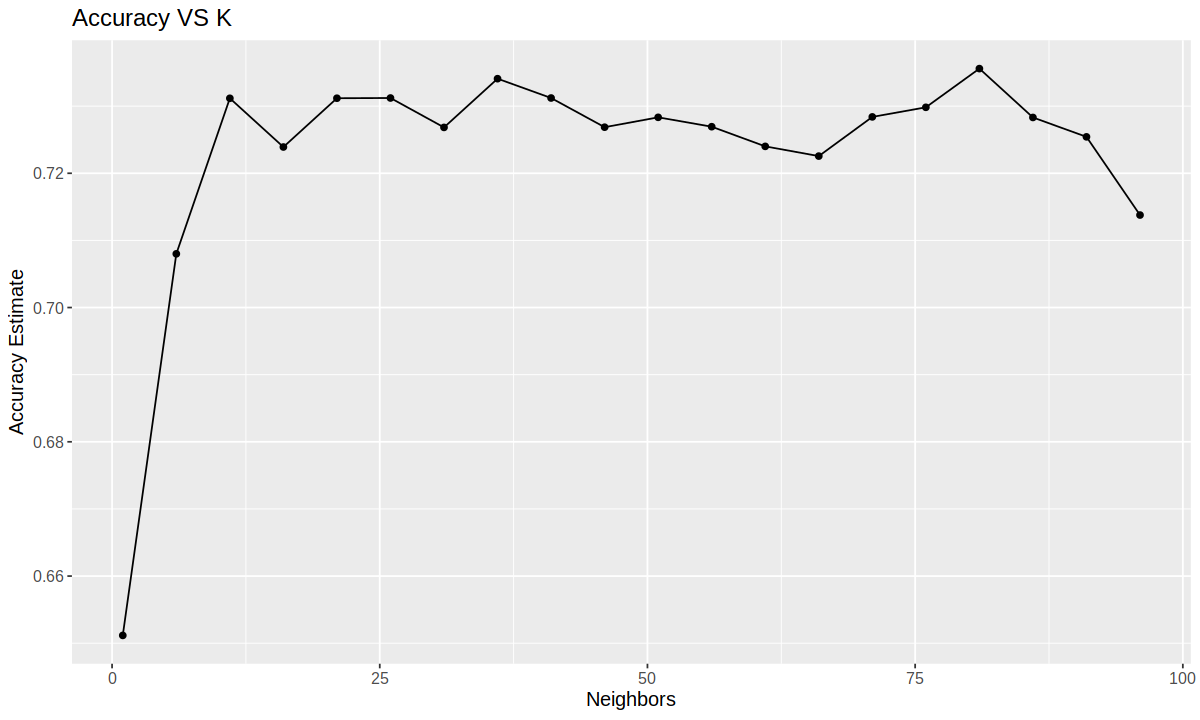

In [20]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))+
    ggtitle("Accuracy VS K")

cat(bold("Plot 2    "))
cat("Accuracy VS Neighbor")
accuracy_vs_k

### Choose the Best K-value:
We chose K=80 as our best K-value, because the accuracy of k=80 is the highest, and changing the value to a nearby one does not decrease accuracy too much.

<font color="grey"> Make a new model specification for the best K, and retrain the classifier using the fit function.

In [27]:
best_knn_spec<-nearest_neighbor(weight_func="rectangular",neighbor=80)|> 
    set_engine("kknn")|> 
    set_mode("classification")

knn_fit<-workflow()|>
    add_recipe(heart_recipe)|> 
    add_model(best_knn_spec)|> 
    fit(data=heart_new_training)

heart_test_predictions<-predict(knn_fit,heart_new_testing)|>
    bind_cols(heart_new_testing)

heart_confusion_matrix<-heart_test_predictions|>
    conf_mat(truth= HeartDisease, estimate= .pred_class)

heart_accuracy<-heart_test_predictions|>
    metrics(truth = HeartDisease, estimate = .pred_class)|>
    filter(.metric == "accuracy")

cat(bold("Table 6   "))
cat("Confusion matrix")
heart_confusion_matrix

cat(bold("Table 7   "))
cat("Acccuracy")
heart_accuracy

Table 6   Confusion matrix

          Truth
Prediction Normal Disease
   Normal      65      29
   Disease     38      98

Table 7   Acccuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7086957


## Visualization
<font color="grey"> Using the ggplot function, we generate six plots to visually assess the performance of the model by comparing the actual and predicted plots.

Plot 3  Age & Cholesterol comparison

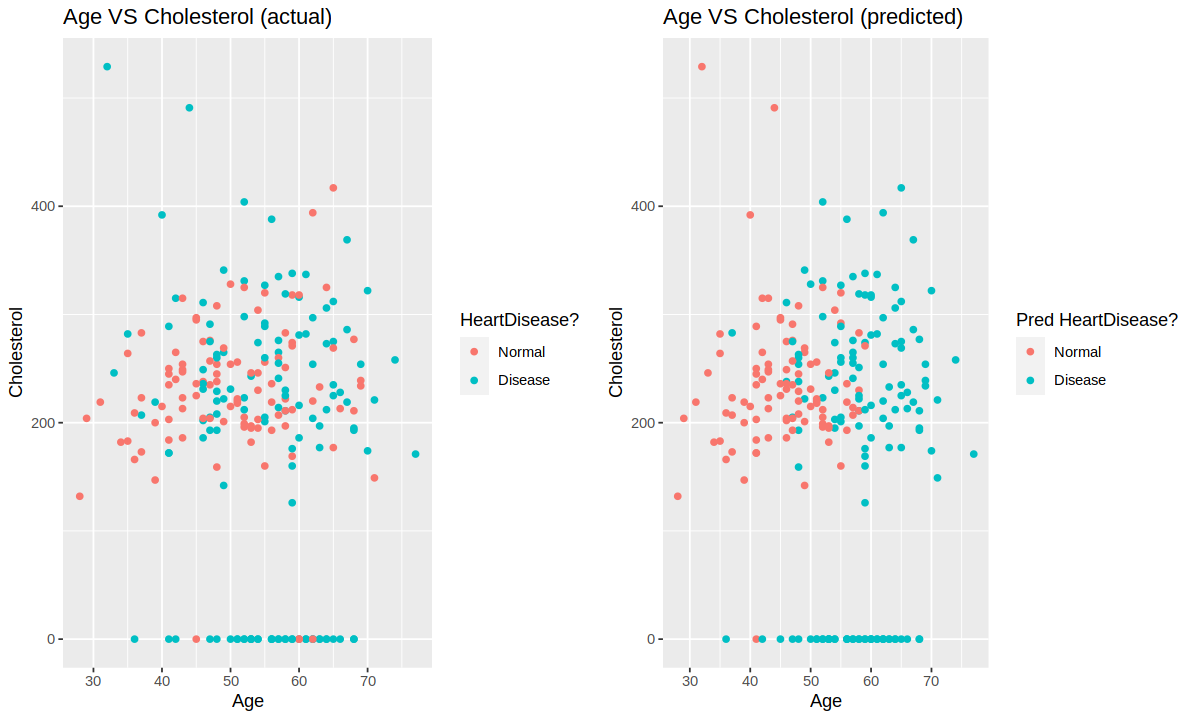

Plot 4  Cholesterol & MaxHR comparison

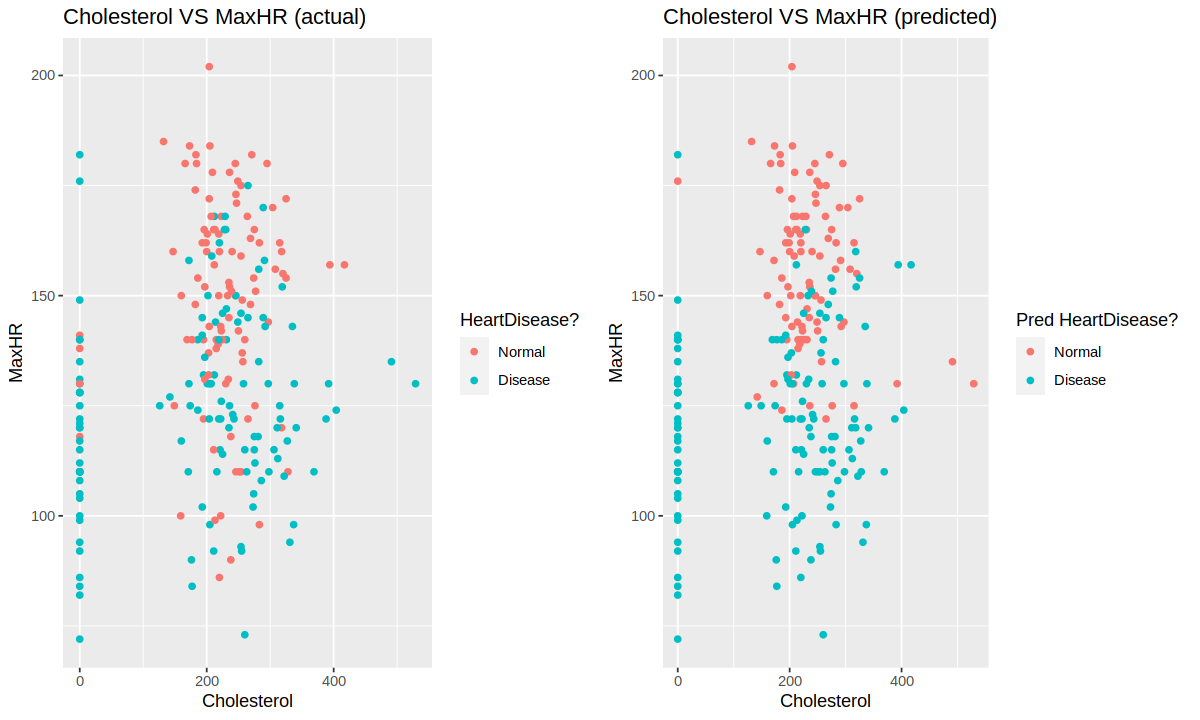

Plot 5  Age & MaxHR comparison

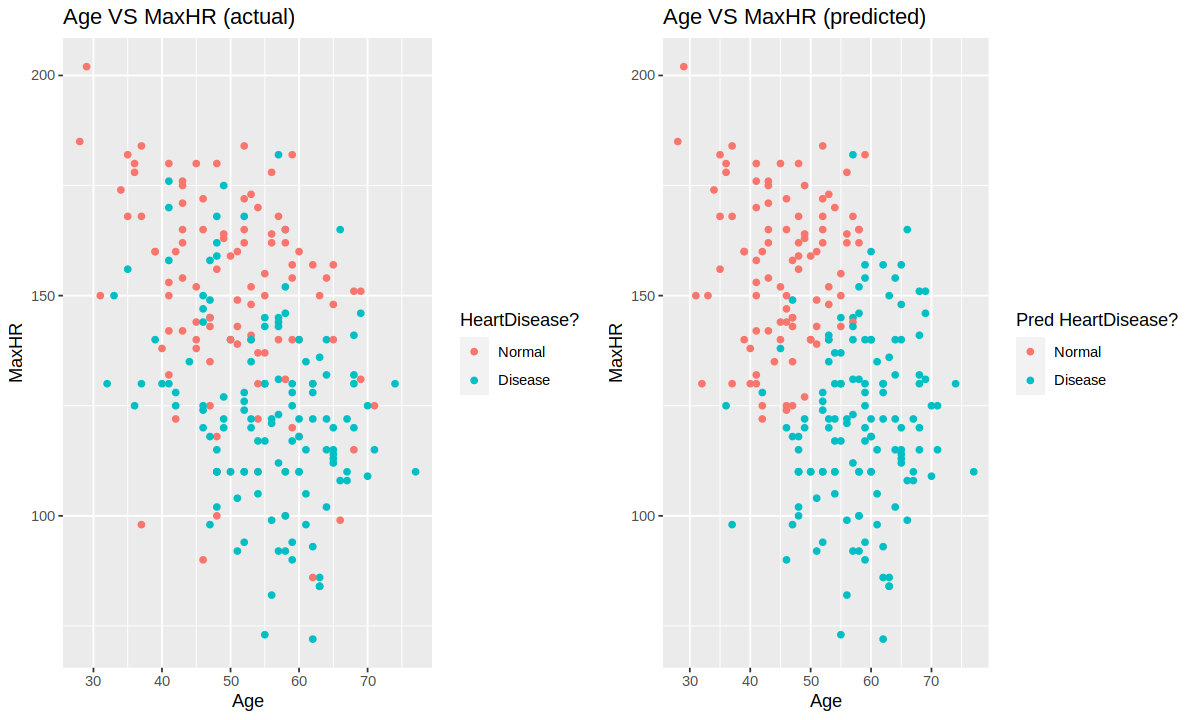

In [18]:
# Actual plot
age_cholesterol_actual_plot<-heart_new_testing|>
    ggplot(aes(x=Age,y=Cholesterol,color=HeartDisease))+
    geom_point() + 
    labs(x="Age", y="Cholesterol", color="HeartDisease?") + 
    ggtitle ("Age VS Cholesterol (actual)")


cholesterol_MaxHR_actual_plot<-heart_new_testing|>
    ggplot(aes(x=Cholesterol,y=MaxHR,color=HeartDisease))+
    geom_point() + 
    labs(x="Cholesterol", y="MaxHR", color="HeartDisease?") + 
    ggtitle ("Cholesterol VS MaxHR (actual)")

age_MaxHR_actual_plot<-heart_new_testing|>
    ggplot(aes(x=Age,y=MaxHR,color=HeartDisease))+
    geom_point() + 
    labs(x="Age", y="MaxHR", color="HeartDisease?") + 
    ggtitle ("Age VS MaxHR (actual)")


# Predicted plot
age_cholesterol_pred_plot<-heart_test_predictions|>
    ggplot(aes(x=Age,y=Cholesterol,color=.pred_class))+
    geom_point() + 
    labs(x="Age", y="Cholesterol", color="Pred HeartDisease?") + 
    ggtitle ("Age VS Cholesterol (predicted)")


cholesterol_MaxHR_pred_plot<-heart_test_predictions|>
    ggplot(aes(x=Cholesterol,y=MaxHR,color=.pred_class))+
    geom_point() + 
    labs(x="Cholesterol", y="MaxHR", color="Pred HeartDisease?") + 
    ggtitle ("Cholesterol VS MaxHR (predicted)")


age_MaxHR_pred_plot<-heart_test_predictions|>
    ggplot(aes(x=Age,y=MaxHR,color=.pred_class))+
    geom_point() + 
    labs(x="Age", y="MaxHR", color="Pred HeartDisease?") + 
    ggtitle ("Age VS MaxHR (predicted)")


#Compare predicted plot and actual plot
age_cholesterol_compare<-plot_grid (age_cholesterol_actual_plot,
                                    age_cholesterol_pred_plot,
                                    ncol=2)

cholesterol_MaxHR_compare<-plot_grid (cholesterol_MaxHR_actual_plot,
                                      cholesterol_MaxHR_pred_plot,
                                      ncol=2)

age_MaxHR_compare<-plot_grid (age_MaxHR_actual_plot,
                                  age_MaxHR_pred_plot,
                                  ncol=2)
                                  
cat(bold("Plot 3  "))
cat("Age & Cholesterol comparison")
age_cholesterol_compare



cholesterol_MaxHR_compare
cat(bold("Plot 4  "))
cat("Cholesterol & MaxHR comparison")



age_MaxHR_compare
cat(bold("Plot 5  "))
cat("Age & MaxHR comparison")


### Analyze the plots:
Overall, as can be seen from the three sets of plots, the predicted plot of each set has obvious clusters for two classes, which are very different from the actual plot of each set. We could conclude that our model is not an effective and accurate model for heart disease prediction.

Age & Cholesterol comparison: Our model does not perform well when predicting the heart disease class for individuals with ages and cholesterol because the red points and blue points in the actual plot are quite mixed. However, this might result from the fact that age and cholesterol were not good predictors from the beginning.


Cholesterol & MaxHR comparison: It seems our model predicted well when considering cholesterol and MaxHR because there are few points being predicted incorrectly. However, some points are predicted incorrectly when MaxHR is between 0 and 125 and when cholesterol is between 200 and 400.


Age & MaxHR comparison: It looks like the predicted plot barely has any overlap between the two groups, whereas the actual plot actually has quite a lot of overlap. This indicates that our model is unable to correctly predict the heart disease class for individuals with a low age and high Max HR. 


## Discussion:

#### What we found:
- **Accuracy=0.708695=70.87%**
- **Precision=98/(38+98)=0.720588=72.06%**
- **Recall=98/(29+98)=0.771654=77.17%**

Since our accuracy is not high enough, the classifier cannot accurately predict an individual's susceptibility to heart disease based on the given features.

#### Whether this is what you expected to find?

We expect to determine whether the classifier can accurately predict an individual's susceptibility to heart disease based on the given features. A good value for accuracy (as well as precision and recall) depends on the application; we must critically analyze them in the context of our problem. 

- ***Recall(77.17%):***

The recall means that the model correctly identified 77.17% of individuals who actually have heart disease.  
In our context, especially in medical context, false negatives (missing actual cases of heart disease) are more concerning. Therefore, we should prioritize recall and try to increase it. A higher recall means the model is better at capturing more instances of positive cases, reducing the chances of missing individuals who actually have heart disease. 


- ***Precision(72.06%):***

The precision means that 72.06% of the individuals predicted to have heart disease actually have it. If false positives (incorrectly predicting heart disease) are more costly, we should prioritize precision. For example, hospitals (or other heart disease prediction institutions) need to bear the costs of incorrectly predicting heart disease, such as unnecessary mental and financial losses to patients. In this case, we should improve accuracy to reduce the cost of errors. Higher precision means a lower rate of false positives.

- ***Accuracy(70.87%):***

The accuracy of our model is 70.87%, indicating that 70.87% of the predictions are correct. A paper titled 'Effectively Predicting the Presence of Coronary Heart Disease Using Machine Learning Classifiers' that we found on the internet demonstrates that the model developed by the author achieves an impressive accuracy of 96%, significantly surpassing the accuracy of our model. This finding suggests that our model lacks high accuracy and is insufficient to serve as an effective heart prediction model.

- ***Summary:***

While the model shows promising performance, further considerations, adjustments, and validation steps are needed to ensure its suitability and reliability in real-life applications, especially in the context of healthcare.

#### What impact could such findings have:

By improving the accuracy and precision of our model, we aim to create a valuable tool for real-life applications, assisting doctors in predicting an individual's susceptibility to heart disease. Moreover, this enhanced classifier could be instrumental in identifying at-risk individuals, allowing for timely interventions. If successful, it has the potential to revolutionize healthcare by enabling early detection, intervention, and more effective allocation of resources, ultimately leading to improved health outcomes and reduced mortality rates.

#### What future questions could this lead to:

- **What other variables could be included in the model to improve the accuracy?**

Due to the low accuracy of our model, it prompts us to explore additional variables that could enhance its predictive performance. As the paper 'Effectively Predicting the Presence of Coronary Heart Disease Using Machine Learning Classifiers' suggests, key risk influences for heart disease include sex, smoking, family history, poor diet, physical inactivity, high blood pressure, overweightness, and alcohol use. Utilizing these variables could potentially improve the accuracy. 

- **Will collecting more data increase our accuracy?** 

Due to the low accuracy of our model, it also prompts us to determine whether collecting more data will improve accuracy. Having more data may enhance our accuracy because our current dataset is not large enough. Usually, the more features a model has, the more data it typically needs. Our model used three predictors; perhaps broadening our dataset could make the model perform better.f

- **Will the classifier perform differently across diverse demographic groups, such as gender or race?**

- **How do the predictive factors and the classifier's accuracy evolve over time, considering changes in lifestyle, healthcare practices, and medical advancements?**


## Reference:

FEDESORIANO. (2021). Heart Failure Prediction Dataset. Www.kaggle.com. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction


Canada, Public Health Agency of. “Heart Disease in Canada.” Www.canada.ca, 10 Feb. 2017, www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html#.


Heart Health and Aging. (n.d.). National Institute on Aging. https://www.nia.nih.gov/health/heart-health/heart-health-and-aging


Centers for Disease Control and Prevention (CDC). (2019, May 14). Heart Health Information: About Heart Disease. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/about.htm


What your heart rate is telling you. (2015, December 11). Harvard Health. https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you#:~:text=A%20%22normal%22%20heart%20rate%20varies


Hassan, Ch. A. ul, Iqbal, J., Irfan, R., Hussain, S., Algarni, A. D., Bukhari, S. S. H., Alturki, N., & Ullah, S. S. (2022). Effectively Predicting the Presence of Coronary Heart Disease Using Machine Learning Classifiers. Sensors, 22(19), 7227. https://doi.org/10.3390/s22197227


